***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.2)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While changing the primary capsule dimension ($P_{capsule} = 16D$). Training with $L_{cons}$
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "5" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  5
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_2_2')

FOLDER CREATED =  ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 16

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 100)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 100)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5160 - prediction_coarse_accuracy: 0.4749 - prediction_medium_accuracy: 0.1937 - prediction_fine_accuracy: 0.0108
  • Coarse Accuracy = 47.49% | Val_Accuracy = 51.07% | LossWeight = 0.35 
  • Medium Accuracy = 19.37% | Val_Accuracy = 28.70% | LossWeight = 0.49 
  • Fine   Accuracy = 1.08% | Val_Accuracy = 1.79% | LossWeight = 0.16 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.01790, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 64s 71ms/step - loss: 0.5160 - prediction_coarse_accuracy: 0.4749 - prediction_medium_accuracy: 0.1937 - prediction_fine_accuracy: 0.0108 - val_loss: 0.4249 - val_prediction_coarse_accuracy: 0.5107 - val_prediction_medium_accuracy: 0.2870 - val_prediction_fine_accuracy: 0.0179 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3548 - prediction_coarse_accur

781/781 [==============================] - ETA: 0s - loss: 0.1931 - prediction_coarse_accuracy: 0.8398 - prediction_medium_accuracy: 0.7454 - prediction_fine_accuracy: 0.1627
  • Coarse Accuracy = 83.98% | Val_Accuracy = 81.68% | LossWeight = 0.27 
  • Medium Accuracy = 74.54% | Val_Accuracy = 69.14% | LossWeight = 0.39 
  • Fine   Accuracy = 16.27% | Val_Accuracy = 15.50% | LossWeight = 0.33 

Epoch 9: val_prediction_fine_accuracy improved from 0.14800 to 0.15500, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 85s 109ms/step - loss: 0.1931 - prediction_coarse_accuracy: 0.8398 - prediction_medium_accuracy: 0.7454 - prediction_fine_accuracy: 0.1627 - val_loss: 0.1821 - val_prediction_coarse_accuracy: 0.8168 - val_prediction_medium_accuracy: 0.6914 - val_prediction_fine_accuracy: 0.1550 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1843 - prediction_coarse_accuracy: 

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1328 - prediction_coarse_accuracy: 0.9212 - prediction_medium_accuracy: 0.8833 - prediction_fine_accuracy: 0.2431
  • Coarse Accuracy = 92.12% | Val_Accuracy = 84.29% | LossWeight = 0.22 
  • Medium Accuracy = 88.33% | Val_Accuracy = 74.34% | LossWeight = 0.29 
  • Fine   Accuracy = 24.31% | Val_Accuracy = 21.91% | LossWeight = 0.49 

Epoch 18: val_prediction_fine_accuracy improved from 0.20160 to 0.21910, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 53s 68ms/step - loss: 0.1328 - prediction_coarse_accuracy: 0.9212 - prediction_medium_accuracy: 0.8833 - prediction_fine_accuracy: 0.2431 - val_loss: 0.1491 - val_prediction_coarse_accuracy: 0.8429 - val_prediction_medium_accuracy: 0.7434 - val_prediction_fine_accuracy: 0.2191 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1301 - prediction_

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.1127 - prediction_coarse_accuracy: 0.9457 - prediction_medium_accuracy: 0.9247 - prediction_fine_accuracy: 0.3378
  • Coarse Accuracy = 94.57% | Val_Accuracy = 84.94% | LossWeight = 0.20 
  • Medium Accuracy = 92.47% | Val_Accuracy = 75.26% | LossWeight = 0.25 
  • Fine   Accuracy = 33.78% | Val_Accuracy = 28.31% | LossWeight = 0.56 

Epoch 27: val_prediction_fine_accuracy improved from 0.27460 to 0.28310, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 91s 117ms/step - loss: 0.1127 - prediction_coarse_accuracy: 0.9457 - prediction_medium_accuracy: 0.9247 - prediction_fine_accuracy: 0.3378 - val_loss: 0.1396 - val_prediction_coarse_accuracy: 0.8494 - val_prediction_medium_accuracy: 0.7526 - val_prediction_fine_accuracy: 0.2831 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1115 - prediction

Epoch 36/100
781/781 [==============================] - ETA: 0s - loss: 0.1049 - prediction_coarse_accuracy: 0.9508 - prediction_medium_accuracy: 0.9353 - prediction_fine_accuracy: 0.4186
  • Coarse Accuracy = 95.08% | Val_Accuracy = 85.47% | LossWeight = 0.20 
  • Medium Accuracy = 93.53% | Val_Accuracy = 76.16% | LossWeight = 0.24 
  • Fine   Accuracy = 41.86% | Val_Accuracy = 34.57% | LossWeight = 0.56 

Epoch 36: val_prediction_fine_accuracy improved from 0.33680 to 0.34570, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 87s 111ms/step - loss: 0.1049 - prediction_coarse_accuracy: 0.9508 - prediction_medium_accuracy: 0.9353 - prediction_fine_accuracy: 0.4186 - val_loss: 0.1336 - val_prediction_coarse_accuracy: 0.8547 - val_prediction_medium_accuracy: 0.7616 - val_prediction_fine_accuracy: 0.3457 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1026 - prediction

Epoch 45/100
781/781 [==============================] - ETA: 0s - loss: 0.0993 - prediction_coarse_accuracy: 0.9545 - prediction_medium_accuracy: 0.9415 - prediction_fine_accuracy: 0.4636
  • Coarse Accuracy = 95.45% | Val_Accuracy = 85.94% | LossWeight = 0.20 
  • Medium Accuracy = 94.15% | Val_Accuracy = 76.66% | LossWeight = 0.24 
  • Fine   Accuracy = 46.36% | Val_Accuracy = 38.03% | LossWeight = 0.56 

Epoch 45: val_prediction_fine_accuracy improved from 0.37740 to 0.38030, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 54s 69ms/step - loss: 0.0993 - prediction_coarse_accuracy: 0.9545 - prediction_medium_accuracy: 0.9415 - prediction_fine_accuracy: 0.4636 - val_loss: 0.1298 - val_prediction_coarse_accuracy: 0.8594 - val_prediction_medium_accuracy: 0.7666 - val_prediction_fine_accuracy: 0.3803 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0993 - prediction_

Epoch 54/100
781/781 [==============================] - ETA: 0s - loss: 0.0962 - prediction_coarse_accuracy: 0.9564 - prediction_medium_accuracy: 0.9462 - prediction_fine_accuracy: 0.4972
  • Coarse Accuracy = 95.64% | Val_Accuracy = 86.38% | LossWeight = 0.21 
  • Medium Accuracy = 94.62% | Val_Accuracy = 76.92% | LossWeight = 0.23 
  • Fine   Accuracy = 49.72% | Val_Accuracy = 39.66% | LossWeight = 0.56 

Epoch 54: val_prediction_fine_accuracy did not improve from 0.39900
781/781 [==============================] - 54s 69ms/step - loss: 0.0962 - prediction_coarse_accuracy: 0.9564 - prediction_medium_accuracy: 0.9462 - prediction_fine_accuracy: 0.4972 - val_loss: 0.1269 - val_prediction_coarse_accuracy: 0.8638 - val_prediction_medium_accuracy: 0.7692 - val_prediction_fine_accuracy: 0.3966 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0956 - prediction_coarse_accuracy: 0.9570 - prediction_medium_accuracy: 0.9459 - prediction_fine_accuracy: 0.

Epoch 63/100
781/781 [==============================] - ETA: 0s - loss: 0.0949 - prediction_coarse_accuracy: 0.9573 - prediction_medium_accuracy: 0.9466 - prediction_fine_accuracy: 0.5123
  • Coarse Accuracy = 95.73% | Val_Accuracy = 86.49% | LossWeight = 0.21 
  • Medium Accuracy = 94.66% | Val_Accuracy = 77.43% | LossWeight = 0.23 
  • Fine   Accuracy = 51.23% | Val_Accuracy = 41.38% | LossWeight = 0.56 

Epoch 63: val_prediction_fine_accuracy improved from 0.41280 to 0.41380, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 48s 61ms/step - loss: 0.0949 - prediction_coarse_accuracy: 0.9573 - prediction_medium_accuracy: 0.9466 - prediction_fine_accuracy: 0.5123 - val_loss: 0.1254 - val_prediction_coarse_accuracy: 0.8649 - val_prediction_medium_accuracy: 0.7743 - val_prediction_fine_accuracy: 0.4138 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0944 - prediction_

781/781 [==============================] - ETA: 0s - loss: 0.0930 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9481 - prediction_fine_accuracy: 0.5326
  • Coarse Accuracy = 95.79% | Val_Accuracy = 86.54% | LossWeight = 0.21 
  • Medium Accuracy = 94.81% | Val_Accuracy = 77.63% | LossWeight = 0.24 
  • Fine   Accuracy = 53.26% | Val_Accuracy = 42.46% | LossWeight = 0.55 

Epoch 81: val_prediction_fine_accuracy improved from 0.42360 to 0.42460, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 74s 95ms/step - loss: 0.0930 - prediction_coarse_accuracy: 0.9579 - prediction_medium_accuracy: 0.9481 - prediction_fine_accuracy: 0.5326 - val_loss: 0.1235 - val_prediction_coarse_accuracy: 0.8654 - val_prediction_medium_accuracy: 0.7763 - val_prediction_fine_accuracy: 0.4246 - lr: 2.6205e-05
Epoch 82/100
781/781 [==============================] - ETA: 0s - loss: 0.0929 - prediction_coarse_accura

781/781 [==============================] - 67s 86ms/step - loss: 0.0925 - prediction_coarse_accuracy: 0.9602 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.5396 - val_loss: 0.1236 - val_prediction_coarse_accuracy: 0.8657 - val_prediction_medium_accuracy: 0.7759 - val_prediction_fine_accuracy: 0.4268 - lr: 1.6515e-05
Epoch 91/100
781/781 [==============================] - ETA: 0s - loss: 0.0921 - prediction_coarse_accuracy: 0.9611 - prediction_medium_accuracy: 0.9503 - prediction_fine_accuracy: 0.5418
  • Coarse Accuracy = 96.11% | Val_Accuracy = 86.69% | LossWeight = 0.20 
  • Medium Accuracy = 95.03% | Val_Accuracy = 77.76% | LossWeight = 0.23 
  • Fine   Accuracy = 54.18% | Val_Accuracy = 42.72% | LossWeight = 0.56 

Epoch 91: val_prediction_fine_accuracy improved from 0.42680 to 0.42720, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 60s 77ms/step - loss: 0.0921 - prediction_coarse_

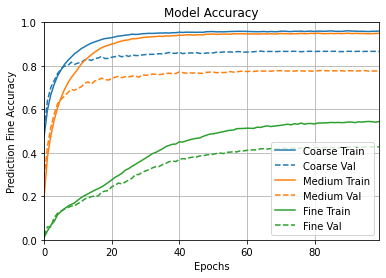

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

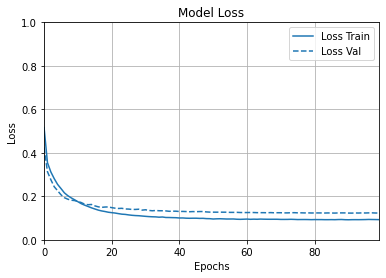

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 20ms/step - loss: 0.3234 - prediction_coarse_loss: 0.1023 - prediction_medium_loss: 0.1684 - prediction_fine_loss: 0.4720 - prediction_coarse_accuracy: 0.8658 - prediction_medium_accuracy: 0.7771 - prediction_fine_accuracy: 0.4275
1. loss ==> 0.3233962953090668
2. prediction_coarse_loss ==> 0.1022585928440094
3. prediction_medium_loss ==> 0.16840620338916779
4. prediction_fine_loss ==> 0.4720415472984314
5. prediction_coarse_accuracy ==> 0.8658000230789185
6. prediction_medium_accuracy ==> 0.7771000266075134
7. prediction_fine_accuracy ==> 0.42750000953674316
313/313 [==============================] - 5s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

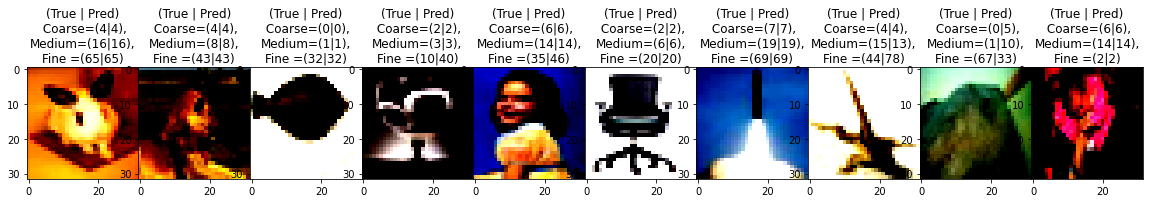

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 734   13   22   24  173   16    9    9]
 [   9 1372   31   29   35   19    1    4]
 [   7   24 1377   21   23   11   14   23]
 [  16   33   37  792  102    3    6   11]
 [ 101   16   51   91 2200    7   13   21]
 [  10   35   25    7   21  869    1   32]
 [   4    7   20   13   36    1  417    2]
 [   8    2   28   13   25   26    1  897]]

  • MEDIUM LEVEL 
[[320  29   0   1   1   8   2   5  19   1   7  16  24   9   2  25  26   1
    3   1]
 [ 34 361   7   4   5   4   2   8   2   4   6   2   2   6   9  26  10   1
    3   4]
 [  0   4 446   6  18   4   1   7   0   1   2   1   0   5   0   2   0   2
    0   1]
 [  1   2   4 415  13  29   7   3   0   1   2   1   0   5   7   4   0   0
    1   5]
 [  2   2  17   7 429   5   1   3   5   1   3   2   1  12   1   5   3   1
    0   0]
 [  0   3   0  26   5 390  31   0   2   2   3   2   2   6   9   3   1   2
    5   8]
 [  2   1   2  12   2  28 427   4   0   3   1   1   2   2   0   3   2   1
    6   1]


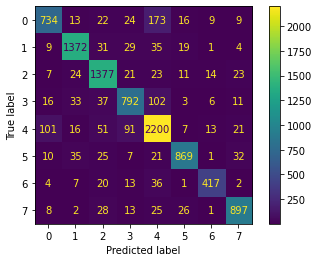

              precision    recall  f1-score   support

           0    0.82565   0.73400   0.77713      1000
           1    0.91345   0.91467   0.91406      1500
           2    0.86549   0.91800   0.89097      1500
           3    0.80000   0.79200   0.79598      1000
           4    0.84130   0.88000   0.86022      2500
           5    0.91282   0.86900   0.89037      1000
           6    0.90260   0.83400   0.86694       500
           7    0.89790   0.89700   0.89745      1000

    accuracy                        0.86580     10000
   macro avg    0.86990   0.85483   0.86164     10000
weighted avg    0.86593   0.86580   0.86525     10000


  • MEDIUM LEVEL 


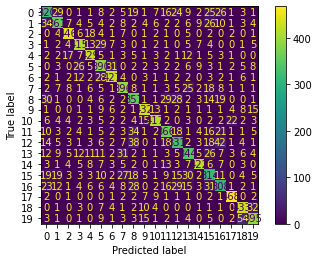

              precision    recall  f1-score   support

           0    0.66116   0.64000   0.65041       500
           1    0.77634   0.72200   0.74819       500
           2    0.87968   0.89200   0.88580       500
           3    0.81693   0.83000   0.82341       500
           4    0.82659   0.85800   0.84200       500
           5    0.70397   0.78000   0.74004       500
           6    0.84891   0.85400   0.85145       500
           7    0.76301   0.79200   0.77723       500
           8    0.67742   0.71400   0.69523       500
           9    0.86228   0.86400   0.86314       500
          10    0.87238   0.83400   0.85276       500
          11    0.75000   0.73200   0.74089       500
          12    0.70576   0.66200   0.68318       500
          13    0.71667   0.68800   0.70204       500
          14    0.89030   0.84400   0.86653       500
          15    0.60153   0.62800   0.61448       500
          16    0.65532   0.61600   0.63505       500
          17    0.91585   0

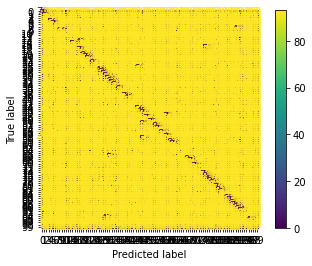

              precision    recall  f1-score   support

           0    0.71560   0.78000   0.74641       100
           1    0.65217   0.75000   0.69767       100
           2    0.33121   0.52000   0.40467       100
           3    0.31818   0.42000   0.36207       100
           4    0.23699   0.41000   0.30037       100
           5    0.33526   0.58000   0.42491       100
           6    0.52985   0.71000   0.60684       100
           7    0.00000   0.00000   0.00000       100
           8    0.00000   0.00000   0.00000       100
           9    0.62963   0.68000   0.65385       100
          10    0.18280   0.34000   0.23776       100
          11    0.00000   0.00000   0.00000       100
          12    0.00000   0.00000   0.00000       100
          13    0.28889   0.39000   0.33191       100
          14    0.00000   0.00000   0.00000       100
          15    0.41844   0.59000   0.48963       100
          16    0.00000   0.00000   0.00000       100
          17    0.00000   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.6892983333333332 
Hierarchical Recall = 0.7013999999999999 
Hierarchical F1-Score = 0.6940325396825396 
Consistency =  0.9223 
Exact Match =  0.4172


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1215 - prediction_coarse_accuracy: 0.9222 - prediction_medium_accuracy: 0.8854 - prediction_fine_accuracy: 0.4337
  • Coarse Accuracy = 92.22% | Val_Accuracy = 82.62% | LossWeight = 0.25 
  • Medium Accuracy = 88.54% | Val_Accuracy = 72.49% | LossWeight = 0.33 
  • Fine   Accuracy = 43.37% | Val_Accuracy = 36.45% | LossWeight = 0.42 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.42750
781/781 [==============================] - 49s 63ms/step - loss: 0.1215 - prediction_coarse_accuracy: 0.9222 - prediction_medium_accuracy: 0.8854 - prediction_fine_accuracy: 0.4337 - val_loss: 0.1482 - val_prediction_coarse_accuracy: 0.8262 - val_prediction_medium_accuracy: 0.7249 - val_prediction_fine_accuracy: 0.3645 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1197 - prediction_coarse_accuracy: 0.9302 - prediction_medium_accuracy: 0.8997 - prediction_fine_accuracy: 0.4508
  

Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1073 - prediction_coarse_accuracy: 0.9418 - prediction_medium_accuracy: 0.9194 - prediction_fine_accuracy: 0.5275
  • Coarse Accuracy = 94.18% | Val_Accuracy = 84.76% | LossWeight = 0.24 
  • Medium Accuracy = 91.94% | Val_Accuracy = 75.17% | LossWeight = 0.30 
  • Fine   Accuracy = 52.75% | Val_Accuracy = 44.41% | LossWeight = 0.46 

Epoch 10: val_prediction_fine_accuracy improved from 0.43640 to 0.44410, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 61s 78ms/step - loss: 0.1073 - prediction_coarse_accuracy: 0.9418 - prediction_medium_accuracy: 0.9194 - prediction_fine_accuracy: 0.5275 - val_loss: 0.1360 - val_prediction_coarse_accuracy: 0.8476 - val_prediction_medium_accuracy: 0.7517 - val_prediction_fine_accuracy: 0.4441 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.1052 - prediction_coar

Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0941 - prediction_coarse_accuracy: 0.9527 - prediction_medium_accuracy: 0.9367 - prediction_fine_accuracy: 0.6279
  • Coarse Accuracy = 95.27% | Val_Accuracy = 85.75% | LossWeight = 0.25 
  • Medium Accuracy = 93.67% | Val_Accuracy = 76.75% | LossWeight = 0.30 
  • Fine   Accuracy = 62.79% | Val_Accuracy = 50.97% | LossWeight = 0.45 

Epoch 19: val_prediction_fine_accuracy improved from 0.49960 to 0.50970, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 87s 112ms/step - loss: 0.0941 - prediction_coarse_accuracy: 0.9527 - prediction_medium_accuracy: 0.9367 - prediction_fine_accuracy: 0.6279 - val_loss: 0.1259 - val_prediction_coarse_accuracy: 0.8575 - val_prediction_medium_accuracy: 0.7675 - val_prediction_fine_accuracy: 0.5097 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0940 - prediction

Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0885 - prediction_coarse_accuracy: 0.9568 - prediction_medium_accuracy: 0.9431 - prediction_fine_accuracy: 0.6956
  • Coarse Accuracy = 95.68% | Val_Accuracy = 85.91% | LossWeight = 0.26 
  • Medium Accuracy = 94.31% | Val_Accuracy = 77.41% | LossWeight = 0.31 
  • Fine   Accuracy = 69.56% | Val_Accuracy = 54.08% | LossWeight = 0.43 

Epoch 28: val_prediction_fine_accuracy improved from 0.54000 to 0.54080, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 85s 109ms/step - loss: 0.0885 - prediction_coarse_accuracy: 0.9568 - prediction_medium_accuracy: 0.9431 - prediction_fine_accuracy: 0.6956 - val_loss: 0.1227 - val_prediction_coarse_accuracy: 0.8591 - val_prediction_medium_accuracy: 0.7741 - val_prediction_fine_accuracy: 0.5408 - lr: 3.9721e-04
Epoch 29/100
781/781 [==============================] - ETA: 0s - loss: 0.0877 - prediction

Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0866 - prediction_coarse_accuracy: 0.9572 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.7375
  • Coarse Accuracy = 95.72% | Val_Accuracy = 86.98% | LossWeight = 0.28 
  • Medium Accuracy = 94.60% | Val_Accuracy = 78.42% | LossWeight = 0.32 
  • Fine   Accuracy = 73.75% | Val_Accuracy = 56.46% | LossWeight = 0.40 

Epoch 37: val_prediction_fine_accuracy did not improve from 0.56640
781/781 [==============================] - 85s 109ms/step - loss: 0.0866 - prediction_coarse_accuracy: 0.9572 - prediction_medium_accuracy: 0.9460 - prediction_fine_accuracy: 0.7375 - val_loss: 0.1186 - val_prediction_coarse_accuracy: 0.8698 - val_prediction_medium_accuracy: 0.7842 - val_prediction_fine_accuracy: 0.5646 - lr: 2.5034e-04
Epoch 38/100
781/781 [==============================] - ETA: 0s - loss: 0.0863 - prediction_coarse_accuracy: 0.9599 - prediction_medium_accuracy: 0.9485 - prediction_fine_accuracy: 0

Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0846 - prediction_coarse_accuracy: 0.9600 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.7644
  • Coarse Accuracy = 96.00% | Val_Accuracy = 86.88% | LossWeight = 0.28 
  • Medium Accuracy = 94.92% | Val_Accuracy = 78.81% | LossWeight = 0.32 
  • Fine   Accuracy = 76.44% | Val_Accuracy = 57.89% | LossWeight = 0.39 

Epoch 46: val_prediction_fine_accuracy improved from 0.57700 to 0.57890, saving model to ../../logs/MOD_2/4_CIFAR_100/HD_CapsNet/TD_W_C_loss_P16\epoch-best.h5
781/781 [==============================] - 84s 107ms/step - loss: 0.0846 - prediction_coarse_accuracy: 0.9600 - prediction_medium_accuracy: 0.9492 - prediction_fine_accuracy: 0.7644 - val_loss: 0.1183 - val_prediction_coarse_accuracy: 0.8688 - val_prediction_medium_accuracy: 0.7881 - val_prediction_fine_accuracy: 0.5789 - lr: 1.5778e-04
Epoch 47/100
781/781 [==============================] - ETA: 0s - loss: 0.0841 - prediction

781/781 [==============================] - 64s 82ms/step - loss: 0.0827 - prediction_coarse_accuracy: 0.9617 - prediction_medium_accuracy: 0.9519 - prediction_fine_accuracy: 0.7842 - val_loss: 0.1178 - val_prediction_coarse_accuracy: 0.8707 - val_prediction_medium_accuracy: 0.7885 - val_prediction_fine_accuracy: 0.5786 - lr: 9.9440e-05
Epoch 56/100
781/781 [==============================] - ETA: 0s - loss: 0.0830 - prediction_coarse_accuracy: 0.9634 - prediction_medium_accuracy: 0.9532 - prediction_fine_accuracy: 0.7844
  • Coarse Accuracy = 96.34% | Val_Accuracy = 87.08% | LossWeight = 0.28 
  • Medium Accuracy = 95.32% | Val_Accuracy = 78.74% | LossWeight = 0.33 
  • Fine   Accuracy = 78.44% | Val_Accuracy = 57.78% | LossWeight = 0.39 

Epoch 56: val_prediction_fine_accuracy did not improve from 0.57890
781/781 [==============================] - 74s 95ms/step - loss: 0.0830 - prediction_coarse_accuracy: 0.9634 - prediction_medium_accuracy: 0.9532 - prediction_fine_accuracy: 0.7844 - 

Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0831 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9517 - prediction_fine_accuracy: 0.7936
  • Coarse Accuracy = 96.21% | Val_Accuracy = 87.19% | LossWeight = 0.29 
  • Medium Accuracy = 95.17% | Val_Accuracy = 79.07% | LossWeight = 0.34 
  • Fine   Accuracy = 79.36% | Val_Accuracy = 58.15% | LossWeight = 0.37 

Epoch 65: val_prediction_fine_accuracy did not improve from 0.58510
781/781 [==============================] - 70s 90ms/step - loss: 0.0831 - prediction_coarse_accuracy: 0.9621 - prediction_medium_accuracy: 0.9517 - prediction_fine_accuracy: 0.7936 - val_loss: 0.1171 - val_prediction_coarse_accuracy: 0.8719 - val_prediction_medium_accuracy: 0.7907 - val_prediction_fine_accuracy: 0.5815 - lr: 5.9539e-05
Epoch 66/100
781/781 [==============================] - ETA: 0s - loss: 0.0832 - prediction_coarse_accuracy: 0.9610 - prediction_medium_accuracy: 0.9506 - prediction_fine_accuracy: 0.

781/781 [==============================] - 78s 100ms/step - loss: 0.0822 - prediction_coarse_accuracy: 0.9632 - prediction_medium_accuracy: 0.9536 - prediction_fine_accuracy: 0.8007 - val_loss: 0.1163 - val_prediction_coarse_accuracy: 0.8738 - val_prediction_medium_accuracy: 0.7918 - val_prediction_fine_accuracy: 0.5813 - lr: 3.7524e-05
Epoch 75/100
781/781 [==============================] - ETA: 0s - loss: 0.0820 - prediction_coarse_accuracy: 0.9623 - prediction_medium_accuracy: 0.9528 - prediction_fine_accuracy: 0.7993
  • Coarse Accuracy = 96.23% | Val_Accuracy = 87.37% | LossWeight = 0.30 
  • Medium Accuracy = 95.28% | Val_Accuracy = 79.07% | LossWeight = 0.33 
  • Fine   Accuracy = 79.93% | Val_Accuracy = 58.35% | LossWeight = 0.37 

Epoch 75: val_prediction_fine_accuracy did not improve from 0.58510
781/781 [==============================] - 78s 99ms/step - loss: 0.0820 - prediction_coarse_accuracy: 0.9623 - prediction_medium_accuracy: 0.9528 - prediction_fine_accuracy: 0.7993 -

781/781 [==============================] - 71s 91ms/step - loss: 0.0817 - prediction_coarse_accuracy: 0.9633 - prediction_medium_accuracy: 0.9545 - prediction_fine_accuracy: 0.8061 - val_loss: 0.1166 - val_prediction_coarse_accuracy: 0.8732 - val_prediction_medium_accuracy: 0.7915 - val_prediction_fine_accuracy: 0.5816 - lr: 1.4160e-05
Epoch 94/100
781/781 [==============================] - ETA: 0s - loss: 0.0816 - prediction_coarse_accuracy: 0.9640 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.8084
  • Coarse Accuracy = 96.40% | Val_Accuracy = 87.33% | LossWeight = 0.29 
  • Medium Accuracy = 95.38% | Val_Accuracy = 79.14% | LossWeight = 0.34 
  • Fine   Accuracy = 80.84% | Val_Accuracy = 58.07% | LossWeight = 0.37 

Epoch 94: val_prediction_fine_accuracy did not improve from 0.58510
781/781 [==============================] - 71s 91ms/step - loss: 0.0816 - prediction_coarse_accuracy: 0.9640 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.8084 - 

In [24]:
history_dict = history.history

(0.0, 1.0)

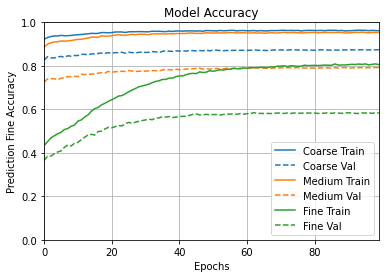

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

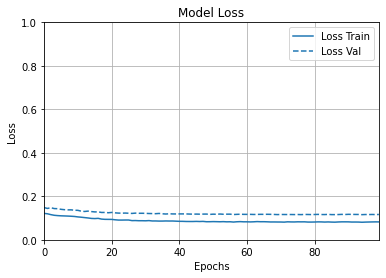

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 11s 26ms/step - loss: 0.2076 - prediction_coarse_loss: 0.0964 - prediction_medium_loss: 0.1594 - prediction_fine_loss: 0.3455 - prediction_coarse_accuracy: 0.8740 - prediction_medium_accuracy: 0.7922 - prediction_fine_accuracy: 0.5831
1. loss ==> 0.20756745338439941
2. prediction_coarse_loss ==> 0.09640958905220032
3. prediction_medium_loss ==> 0.15939493477344513
4. prediction_fine_loss ==> 0.3455023169517517
5. prediction_coarse_accuracy ==> 0.8740000128746033
6. prediction_medium_accuracy ==> 0.7922000288963318
7. prediction_fine_accuracy ==> 0.5831000208854675
313/313 [==============================] - 6s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

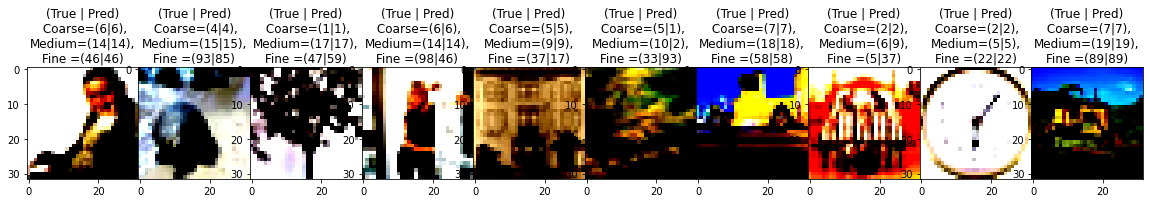

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 740   12   21   28  166   10   10   13]
 [  10 1386   23   22   36   17    5    1]
 [   5   21 1374   21   25   12   16   26]
 [  16   30   25  815   92    4    5   13]
 [  88   21   44   92 2215   12   12   16]
 [   9   28   28    5   30  876    1   23]
 [   5    9   14   10   37    1  421    3]
 [   5    2   28    6   23   22    1  913]]

  • MEDIUM LEVEL 
[[329  27   0   1   1   5   2   4  17   1   4  13  20   8   1  31  28   0
    5   3]
 [ 35 369   5   6   5   3   1  10   2   2   5   3   2  11   9  19   6   1
    3   3]
 [  0   4 457   3  13   0   0   9   2   2   2   0   0   1   2   3   0   0
    1   1]
 [  1   1   5 411   9  27   8   2   1   2   1   2   0   9   7   5   0   0
    2   7]
 [  2   3  19   6 424   9   2   4   5   0   3   3   2   8   3   4   3   0
    0   0]
 [  1   1   0  21   5 404  23   2   0   3   3   1   2   5  11   3   3   2
    4   6]
 [  2   2   0  12   1  28 429   4   0   4   1   1   2   4   1   1   0   1
    7   0]


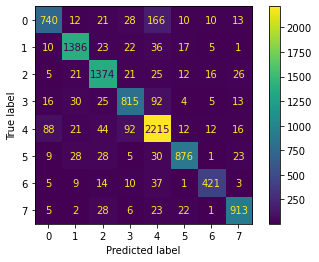

              precision    recall  f1-score   support

           0    0.84282   0.74000   0.78807      1000
           1    0.91849   0.92400   0.92124      1500
           2    0.88247   0.91600   0.89892      1500
           3    0.81582   0.81500   0.81541      1000
           4    0.84413   0.88600   0.86456      2500
           5    0.91824   0.87600   0.89662      1000
           6    0.89384   0.84200   0.86715       500
           7    0.90575   0.91300   0.90936      1000

    accuracy                        0.87400     10000
   macro avg    0.87770   0.86400   0.87017     10000
weighted avg    0.87413   0.87400   0.87347     10000


  • MEDIUM LEVEL 


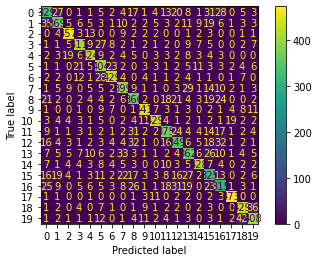

              precision    recall  f1-score   support

           0    0.68685   0.65800   0.67211       500
           1    0.79870   0.73800   0.76715       500
           2    0.88395   0.91400   0.89872       500
           3    0.83537   0.82200   0.82863       500
           4    0.85657   0.84800   0.85226       500
           5    0.73056   0.80800   0.76733       500
           6    0.87018   0.85800   0.86405       500
           7    0.77176   0.79800   0.78466       500
           8    0.69714   0.73200   0.71415       500
           9    0.88200   0.88200   0.88200       500
          10    0.89937   0.85800   0.87820       500
          11    0.77640   0.75000   0.76297       500
          12    0.71811   0.69800   0.70791       500
          13    0.70703   0.72400   0.71542       500
          14    0.88066   0.85600   0.86815       500
          15    0.62023   0.65000   0.63477       500
          16    0.66879   0.63000   0.64882       500
          17    0.93110   0

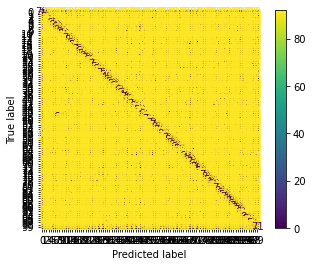

              precision    recall  f1-score   support

           0    0.79798   0.79000   0.79397       100
           1    0.92683   0.76000   0.83516       100
           2    0.44167   0.53000   0.48182       100
           3    0.47191   0.42000   0.44444       100
           4    0.46377   0.32000   0.37870       100
           5    0.62500   0.65000   0.63725       100
           6    0.81176   0.69000   0.74595       100
           7    0.60577   0.63000   0.61765       100
           8    0.52023   0.90000   0.65934       100
           9    0.79310   0.69000   0.73797       100
          10    0.33533   0.56000   0.41948       100
          11    0.29167   0.21000   0.24419       100
          12    0.58140   0.75000   0.65502       100
          13    0.52294   0.57000   0.54545       100
          14    0.41958   0.60000   0.49383       100
          15    0.65060   0.54000   0.59016       100
          16    0.00000   0.00000   0.00000       100
          17    0.86517   0

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.74695 
Hierarchical Recall = 0.7598 
Hierarchical F1-Score = 0.7519654761904762 
Consistency =  0.9176 
Exact Match =  0.57
